<a href="https://colab.research.google.com/github/yfhkucing/experiment_bms/blob/master/Heatmap_with_model_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 1.3 MB/s 


In [2]:
import joblib
import numpy as np
import pandas as pd

In [3]:
! unzip /content/model_30_a0001_norm.zip

Archive:  /content/model_30_a0001_norm.zip
   creating: content/models/
  inflating: content/models/model 25  
  inflating: content/models/model 18  
  inflating: content/models/model 27  
  inflating: content/models/model 4  
  inflating: content/models/model 23  
  inflating: content/models/model 26  
  inflating: content/models/model 3  
  inflating: content/models/model 11  
  inflating: content/models/model 0  
  inflating: content/models/model 21  
  inflating: content/models/model 14  
  inflating: content/models/model 9  
  inflating: content/models/model 2  
  inflating: content/models/model 13  
  inflating: content/models/model 19  
  inflating: content/models/model 8  
  inflating: content/models/model 16  
  inflating: content/models/model 12  
  inflating: content/models/model 28  
  inflating: content/models/model 10  
  inflating: content/models/model 6  
  inflating: content/models/model 29  
  inflating: content/models/model 5  
  inflating: content/models/model 15  


In [4]:
feature = pd.read_excel('data_model.xlsx',sheet_name='feature')
label = pd.read_excel('data_model.xlsx',sheet_name='label_30')

In [6]:
def norm(df):
  df=(df-df.min())/(df.max()-df.min())
  return df

def remap(df,new_max,new_min):
  df = (df-df.min())/(df.max()-df.min())*(new_max - new_min) + new_min
  return df

from sklearn.preprocessing import StandardScaler
def standard(df):
  scaler = StandardScaler()
  df = scaler.fit_transform(df)
  return df

def rescale(df,df2):
  new_max = df2.max()
  new_min = df2.min()
  df = (df)*(new_max - new_min) + new_min
  return df

In [7]:
feature = norm(feature)

In [11]:
array_y = []
array_y_not_normal = []
for i in range(30):
  frame= label[i::30]
  frame = frame.drop(['koor_x','koor_y'],axis=1)
  frame = frame.drop(['Vx','Vy'],axis=1)
  array_y_not_normal.append(frame)
  frame = norm(frame)
  array_y.append(frame)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

skor_r2=[]
mae_=[]
rmse = []
y_predict = []
y_test = []
for i in range(30):
  x = np.array(feature)
  y = np.array(array_y[i])
  model = joblib.load(f'/content/content/models/model {i}')
  y_pred = model.predict(x)
  Skor_r2 = r2(y,y_pred)
  RMSE = mse(y,y_pred,squared=False)
  MAE = mae(y,y_pred)
  y_predict.append(y_pred)
  skor_r2.append(Skor_r2)
  mae_.append(MAE)
  rmse.append(RMSE)

In [15]:
skor_r2 = np.array(skor_r2)
rmse = np.array(rmse)
mae_=np.array(mae_)
y_predict = np.array(y_predict)
y = np.array(array_y)

In [16]:
#error per skenario

r_squared = []
abs_error = []
sqrt_error = []
for i in range(192):
  a = y[...,i,0]
  b = y_predict[...,i]
  r_squared.append(r2(a,b))
  abs_error.append(mae(a,b))
  sqrt_error.append(mse(a,b))

In [17]:
error = pd.DataFrame(r_squared,columns=['r2'])
abs_error = pd.DataFrame(abs_error,columns=['mae'])
sqrt_error = pd.DataFrame(sqrt_error,columns=['rmse'])
error = error.join(abs_error)
error = error.join(sqrt_error)

In [26]:
df_koor = pd.read_excel('data_model.xlsx',sheet_name='koordinat_30_aktual')

In [27]:
df_y = []
df_y_predict = []
for i in range(30):
  q = pd.DataFrame(y[i],columns=['Temp'])
  q = round(rescale(q,array_y_not_normal[i]),9)
  df_y.append(q)
  r = round(pd.DataFrame(y_predict[i],columns=['Temp']),9)
  r = rescale(r,array_y_not_normal[i])
  df_y_predict.append(r)

In [28]:
def suhu(y,scenarios):
  df_x = pd.DataFrame(y[...,scenarios,0])
  df_x = df_x.join(df_koor)
  df_x.rename(columns={0:'Temp'},inplace=True)
  return df_x

In [29]:
#error per skenario

r_squared = []
abs_error = []
sqrt_error = []
indexing = 0,1
for i in range(192):
  a = suhu(np.array(df_y),i)
  a.drop(['koor_x','koor_y'],axis=1)
  b = suhu(np.array(df_y_predict),i)
  b.drop(['koor_x','koor_y'],axis=1)
  r_squared.append(r2(a,b))
  abs_error.append(mae(a,b))
  sqrt_error.append(mse(a,b))

error = pd.DataFrame(r_squared,columns=['r2'])
abs_error = pd.DataFrame(abs_error,columns=['mae'])
sqrt_error = pd.DataFrame(sqrt_error,columns=['rmse'])
error = error.join(abs_error)
error = error.join(sqrt_error)

In [30]:
error.describe()

,r2,mae,rmse
count,192.000000,192.000000,192.000000
mean,0.470006,0.431498,0.985852
std,1.481320,0.299594,1.148082
min,-12.220564,0.053752,0.013232
25%,0.630498,0.151187,0.106445
50%,0.898773,0.386277,0.525368
75%,0.971126,0.655874,1.587635
max,0.996769,1.274811,5.613169


In [31]:
min_error = error[error.r2 == error.r2.max()]
min_error

,r2,mae,rmse
117,0.996769,0.05919,0.014805


In [32]:
max_error = error[error.r2 == error.r2.min()]
max_error

,r2,mae,rmse
59,-12.220564,0.773119,2.285103


In [33]:
writer = pd.ExcelWriter('temp_30_a0001.xlsx')

# Write each dataframe to a different worksheet.
error.to_excel(writer, sheet_name='metric',index=False)
error.describe().to_excel(writer, sheet_name='metric summary',index=False)
min_error.to_excel(writer, sheet_name='minimum error',index=False)
max_error.to_excel(writer, sheet_name='maximum error',index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [34]:
r2_matrix = skor_r2.reshape(5,6)
rmse_matrix = rmse.reshape(5,6)
mae_matrix = mae_.reshape(5,6)

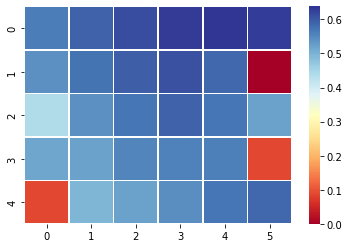

In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

ax = sns.heatmap(r2_matrix, linewidth=0.5, cmap="RdYlBu")
plt.show()

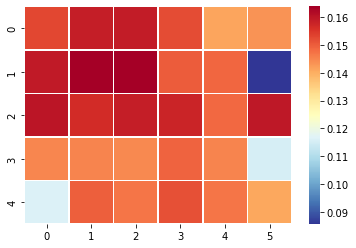

In [36]:
bx = sns.heatmap(rmse_matrix, linewidth=0.5, cmap="RdYlBu_r")
plt.show()

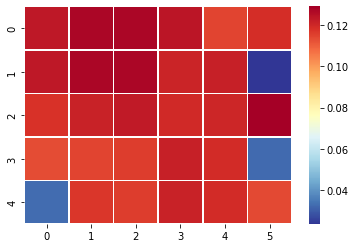

In [37]:
bx = sns.heatmap(mae_matrix, linewidth=0.5, cmap="RdYlBu_r")
plt.show()

In [38]:
! mkdir subplot

In [39]:
df_koor = pd.read_excel('data_model.xlsx',sheet_name='koordinat_30')

In [40]:
def suhu(y):
  df_y = pd.DataFrame(y)
  df_z = pd.DataFrame(y)
  df_z.rename(columns={0:1},inplace=True)
  df_y = df_y.join(df_z)
  df_y = df_y.join(df_koor)
  df_y.rename(columns={0:'Vx',1:'suhu'},inplace=True)
  df_y.pop('Vx')
  return df_y

In [41]:
from plotly.subplots import make_subplots
for i in range(192):
  a = y[(...,i,0)]
  b = y_predict[(...,i)]
  a = np.array(a)
  b = np.array(b)
  a = suhu(a)
  b = suhu(b)
  
  fig = make_subplots(rows=1, cols=2)

  fig.add_contour(
     z = a['suhu'].tolist(),
     x = a['koor_x'].tolist(),
     y = a['koor_y'].tolist(),
     row=1, col=1
  )

  fig.add_contour(
     z = b['suhu'].tolist(),
     x = b['koor_x'].tolist(),
     y = b['koor_y'].tolist(),
     row=1, col=2
  )
  fig.write_image(f'/content/subplot/fig {i}.png')

In [ ]:
!zip -r /content/subplot.zip /content/subplot

  adding: content/subplot/ (stored 0%)
  adding: content/subplot/fig 39.png (deflated 3%)
  adding: content/subplot/fig 104.png (deflated 6%)
  adding: content/subplot/fig 172.png (deflated 4%)
  adding: content/subplot/fig 146.png (deflated 4%)
  adding: content/subplot/fig 153.png (deflated 5%)
  adding: content/subplot/fig 70.png (deflated 4%)
  adding: content/subplot/fig 32.png (deflated 4%)
  adding: content/subplot/fig 180.png (deflated 4%)
  adding: content/subplot/fig 84.png (deflated 4%)
  adding: content/subplot/fig 93.png (deflated 4%)
  adding: content/subplot/fig 189.png (deflated 5%)
  adding: content/subplot/fig 0.png (deflated 4%)
  adding: content/subplot/fig 125.png (deflated 4%)
  adding: content/subplot/fig 3.png (deflated 3%)
  adding: content/subplot/fig 137.png (deflated 4%)
  adding: content/subplot/fig 144.png (deflated 5%)
  adding: content/subplot/fig 67.png (deflated 4%)
  adding: content/subplot/fig 129.png (deflated 5%)
  adding: content/subplot/fig 135.p